In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow import keras
from patchify import patchify
import tifffile as tiff

In [3]:
from utils.deeplab_v3_plus import DeeplabV3Plus
from utils.losses import Jaccard,lovasz_softmax
from utils.elastic_transform import elastic_transform
from tensorflow.keras.applications.resnet50 import preprocess_input

In [50]:
#import all the images
dataset_path = r'C:\Users\Avinash\Desktop\New folder\Project\dataset\coco_dataset_test'
images_path = os.path.join(dataset_path,r'images')
masks_path = os.path.join(dataset_path,'masks')
images = []
masks = []
for image in os.listdir(images_path):
    img_t = cv2.imread(os.path.join(images_path,image))
    gray_img_t = cv2.cvtColor(img_t,cv2.COLOR_BGR2GRAY)
    bin_gray_img_t = cv2.adaptiveThreshold(gray_img_t,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    bin_gray_img_t = cv2.medianBlur(bin_gray_img_t,3)
    if bin_gray_img_t.shape != (1024,2048):
        resize_2_1080p = cv2.resize(bin_gray_img_t,(1024,2048),interpolation=cv2.INTER_LANCZOS4)
    images.append(np.array(resize_2_1080p))
for mask in os.listdir(masks_path):
    masks.append(np.array(cv2.resize(
        cv2.imread(os.path.join(masks_path,mask),cv2.IMREAD_GRAYSCALE),(1024,2048),
        interpolation=cv2.INTER_LINEAR_EXACT)))
print(masks[0].shape,images[0].shape)

(2048, 1024) (2048, 1024)


In [51]:
#patchify the images
images = np.array(images)
masks = np.array(masks)
from patchify import patchify
patch_images = []
for i in range(images.shape[0]):
    single_patches = patchify(images[i],(512,512),step=512)
    for j in range(single_patches.shape[0]):
        for k in range(single_patches.shape[1]):
            t = single_patches[j,k,:,:]
            t = np.array(t,dtype=np.float32)/255.
            patch_images.append(t)
patch_masks = []
for i in range(masks.shape[0]):
    single_patches = patchify(masks[i],(512,512),step=512)
    for j in range(single_patches.shape[0]):
        for k in range(single_patches.shape[1]):
            t = single_patches[j,k,:,:]
            t = np.array(t,dtype='float32')/255.
            patch_masks.append(t)


In [52]:
patch_images = np.array(patch_images)
patch_images = np.stack((patch_images,)*3,axis=-1)

patch_masks = np.array(patch_masks)
patch_masks = np.expand_dims(patch_masks,axis=-1)

In [53]:
print(patch_images.shape)
print(patch_masks.shape)
un = np.unique(patch_masks)
print("Pixel values in the mask are: ", un,len(un))

(288, 512, 512, 3)
(288, 512, 512, 1)
Pixel values in the mask are:  [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.04313726] 11


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patch_images, patch_masks, test_size = 0.25, random_state = 42)
print(X_train.shape)
print(X_test.shape)

(216, 512, 512, 3)
(72, 512, 512, 3)


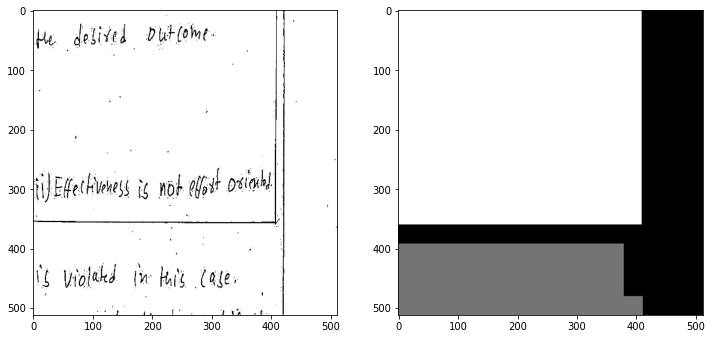

In [60]:
import random
import matplotlib.pyplot as plt
image_number = random.randint(0, len(X_train))
img = X_train[image_number]
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow((np.reshape(X_train[image_number], (512, 512,3))), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (512, 512)), cmap='gray')
plt.show()

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_data_gen_args = dict(rotation_range=1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     fill_mode='nearest',
                     preprocessing_function=preprocess_input)

mask_data_gen_args = dict(rotation_range=1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     fill_mode='nearest') 
seed = 69
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train,batch_size=16, seed=seed)
valid_img_generator = image_data_generator.flow(X_test,batch_size=16, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train,batch_size=16, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test,batch_size=16, seed=seed)


In [26]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

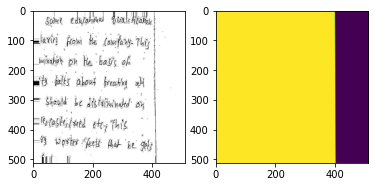

In [39]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()


In [12]:
model = DeeplabV3Plus(image_size=(512,512,3),num_classes=12)
model.compile(optimizer ='Adam',loss=lovasz_softmax,metrics=[Jaccard]) #categorical_crossentropy

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=25)

Epoch 1/25
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv1_conv/Conv2D (defined at <ipython-input-14-439ed13c8df2>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_17122]

Function call stack:
train_function


In [12]:
from utils.test import Deeplabv3


In [13]:
model_2 = Deeplabv3(classes=12,backbone='xception')

AttributeError: module 'tensorflow.keras.backend' has no attribute 'tf'